In [72]:
import spacy
import numpy as np
import pandas as pd
import re
import jsonlines
from utils.prepare_rules import create_rules 
from utils.prepare_data import create_prepare_file
from utils.expand_model import expand_model
from utils.chart import show_2_pie,show_bar_model
from utils.table import show_table, show_empty_brand
from tqdm import tqdm
import os.path
from spacy.language import Language
from spacy import displacy
import matplotlib.pyplot as plt
import ru_core_news_sm

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/util.py:841: UserWarning: [W094] Model 'en_core_web_sm' (2.2.0) specifies an under-constrained spaCy version requirement: >=2.2.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.2.4,<3.3.0
  warnings.warn(warn_msg)


In [2]:
DATA='data/pledges - pledges.csv'
BRANDS='data/brands.jsonl'
RULES='data/rules.jsonl'
DATA_PREPARE='data/pledges_prepare.csv'

BRAND_PATH = 'data/brands/'
RULES_PATH = 'data/rules/'

### Загружаем данные для парсинга и данные по брендам

In [3]:
data = pd.read_csv(DATA, delimiter='|')

In [4]:
brands = list(jsonlines.open(BRANDS))
list_brands = [x['id'] for x in brands]

### Генерируем правила для моделей и марок и сохраняем их в файлы

In [5]:
rules = create_rules(brands)

# save in file
with jsonlines.open(RULES, mode='w') as writer:
    writer.write_all(rules)
    
for brand in list_brands:
    rules_model = create_rules(brands)
    try:
        models = jsonlines.open(BRAND_PATH + brand +'.jsonl')
        rules_model = create_rules(models, label='MODEL', prefix=brand+'_')
        with jsonlines.open(RULES_PATH + brand + '_rules.jsonl', mode='w') as writer:
            writer.write_all(rules_model)
    except:
        print('Для бренда '+ brand+ ' не найден файл с моделями ' + BRAND_PATH + brand +'.jsonl')
        pass

### Попытаемся отбить пробелы
Возможно это не слишком хорошая идея...

In [6]:
list_models = []
for brand in list_brands:
    try:
        reader = jsonlines.open(BRAND_PATH + brand +'.jsonl')
        list_models = list_models + list(reader)
    except:
        print('Для бренда '+ brand+ ' не найден файл с правилами ' + BRAND_PATH + brand +'.jsonl')
        pass

In [7]:
str_with_space = create_prepare_file(data=data['vehicleproperty_description_short'].values, brands=brands+list_models)

data['with_space'] = str_with_space
data.to_csv(DATA_PREPARE, index=False)

In [8]:
data = pd.read_csv(DATA_PREPARE, delimiter=',')

### NER

In [9]:
rules = list(jsonlines.open(RULES))
for brand in list_brands:
    if os.path.exists(RULES_PATH + brand + '_rules.jsonl'):
            file = jsonlines.open(RULES_PATH + brand + '_rules.jsonl')
            rules = rules + (list(file))
    else:
        print('fail')

In [73]:
colors = {"BRAND": "#aa9cfc", "MODEL": "#fc9ce7"}
options = {"ents": ["BRAND", "MODEL"], "colors": colors}

nlp = ru_core_news_sm.load(exclude=['tok2vec', 'morphologizer', 'parser', 'senter', 'attribute_ruler', 'lemmatizer'])

config = { "overwrite_ents": True }
ruler = nlp.add_pipe("entity_ruler", before="ner", config=config) #.from_disk(RULES_PATH +"all_rules.jsonl", )
ruler.add_patterns(rules)

nlp.add_pipe("expand_model", after="ner")

ents_info = []
html=[]
for article in tqdm(data['with_space']):
    article = str(article)
    doc = nlp(article)
    ents_info.append(doc.user_data)
    html.append(doc if len(doc.ents) == 0 else displacy.render(doc, style="ent", jupyter=False, options=options))
    


OSError: [E053] Could not read config file from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/en_core_web_sm/en_core_web_sm-2.2.0/config.cfg

In [11]:
ents_info_df = pd.DataFrame.from_records(ents_info)
data.index.name = 'order'
data = data.join(ents_info_df,on='order')
data = data.assign(HTML = html)
data.index.name= 'id'

### График опознанных брендов и моделей

/home/cosysoft/Documents/autostat/autostat/utils/chart.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['count_models']!=0][data['have_fit_model'] == False].shape[0],


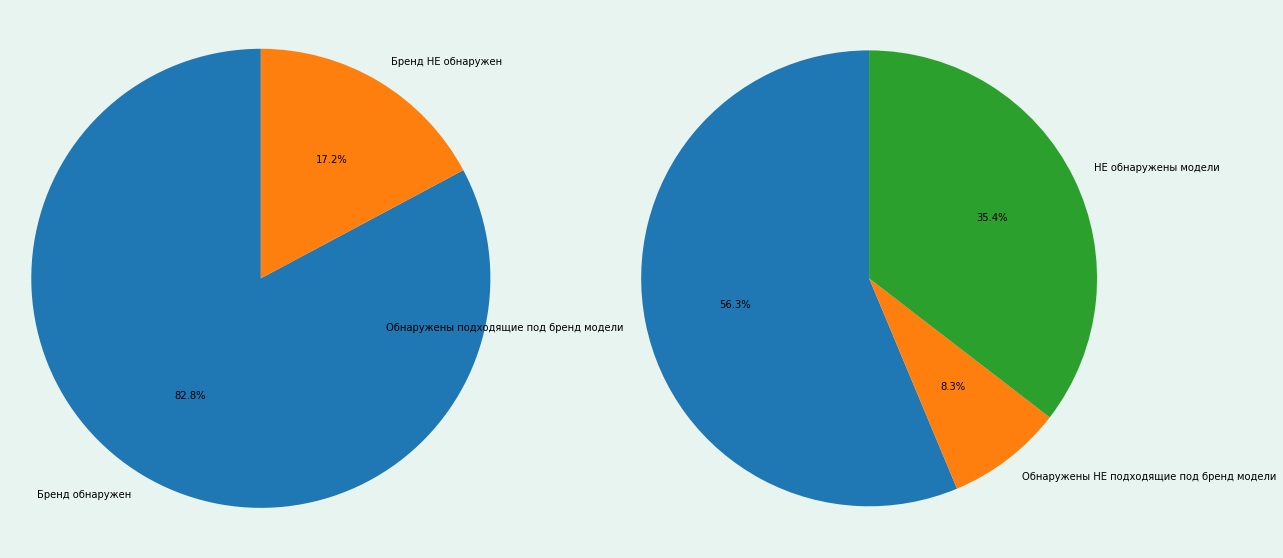

In [12]:
show_2_pie(data)

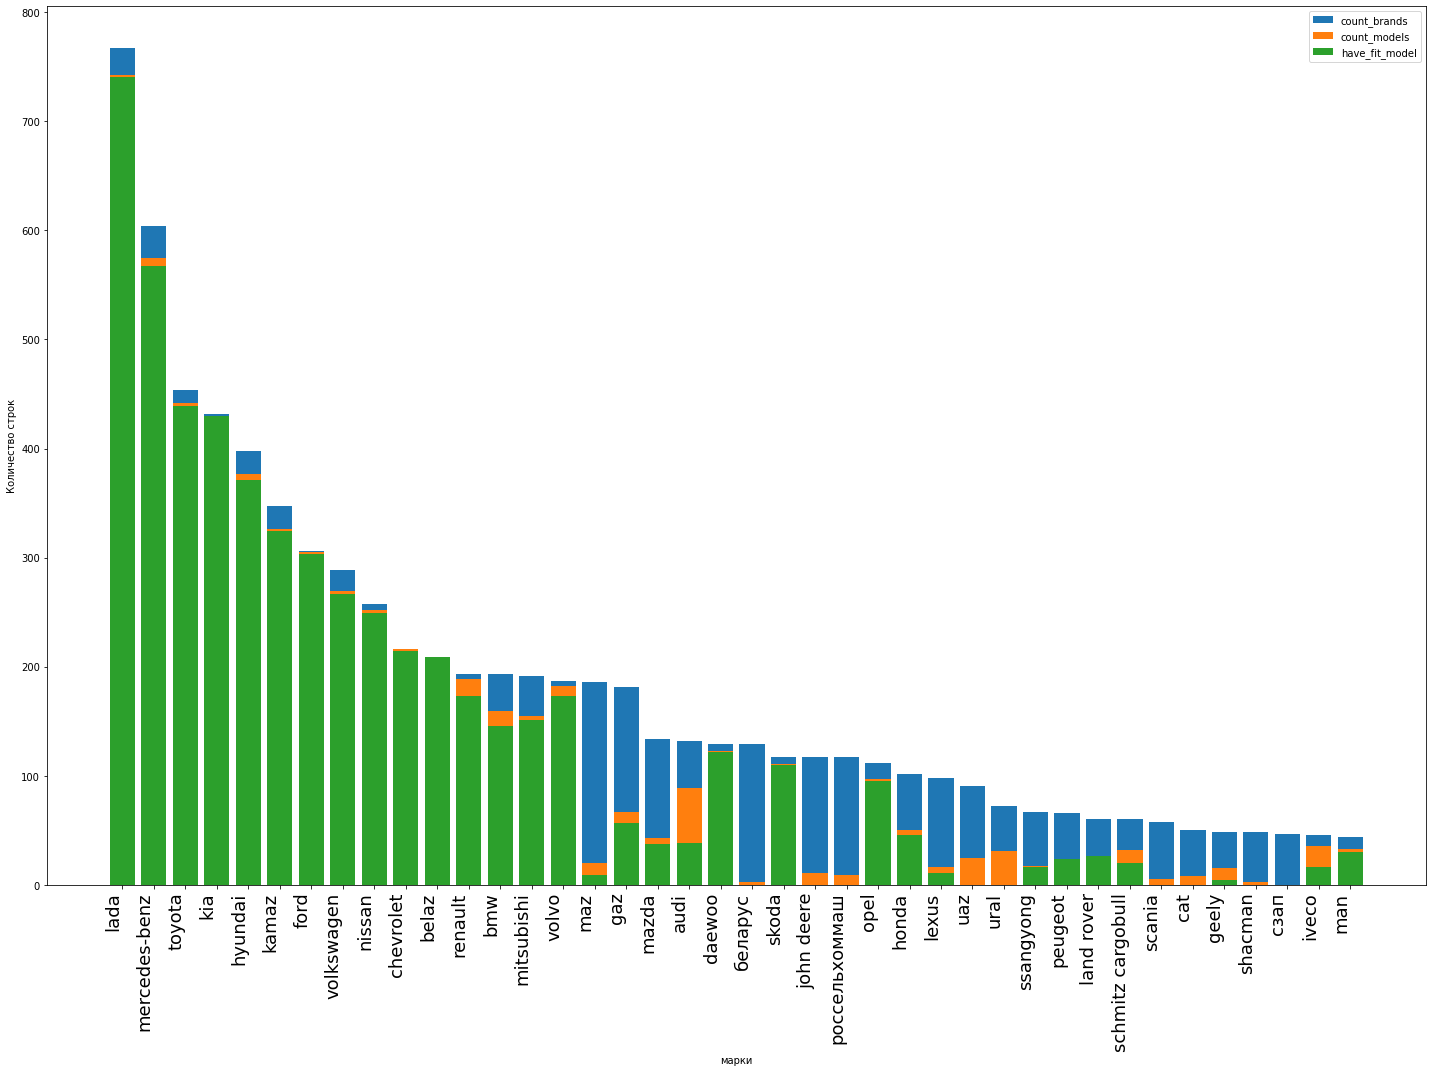

In [18]:
show_bar_model(data, 0, 40)

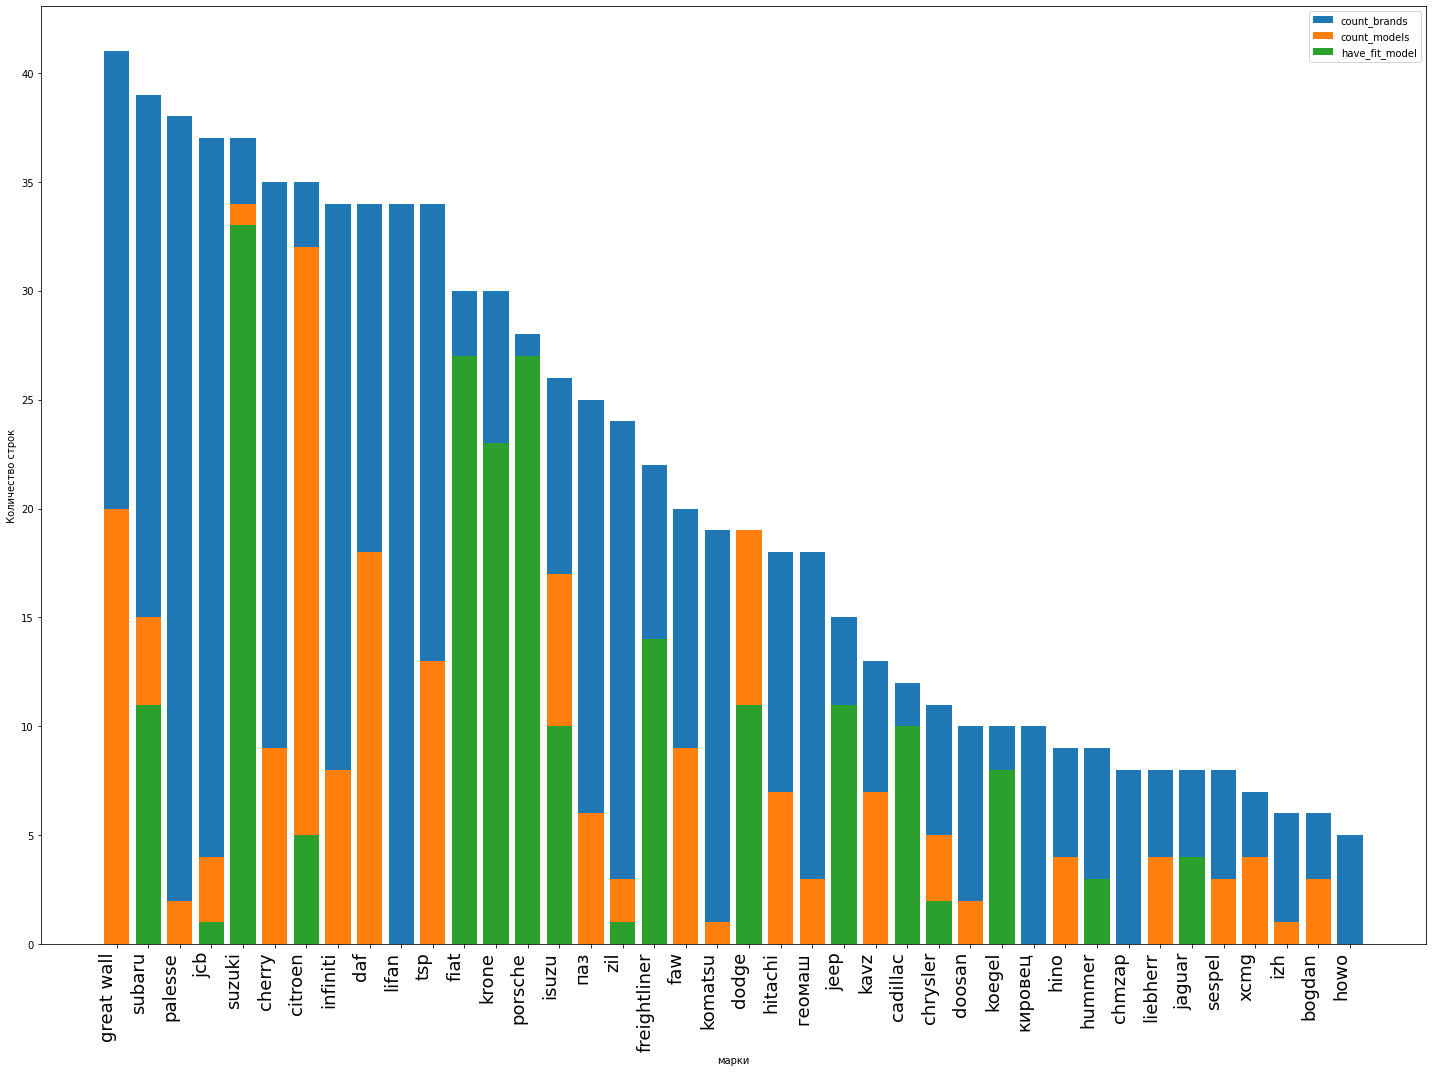

In [14]:
show_bar_model(data, 40, 80)

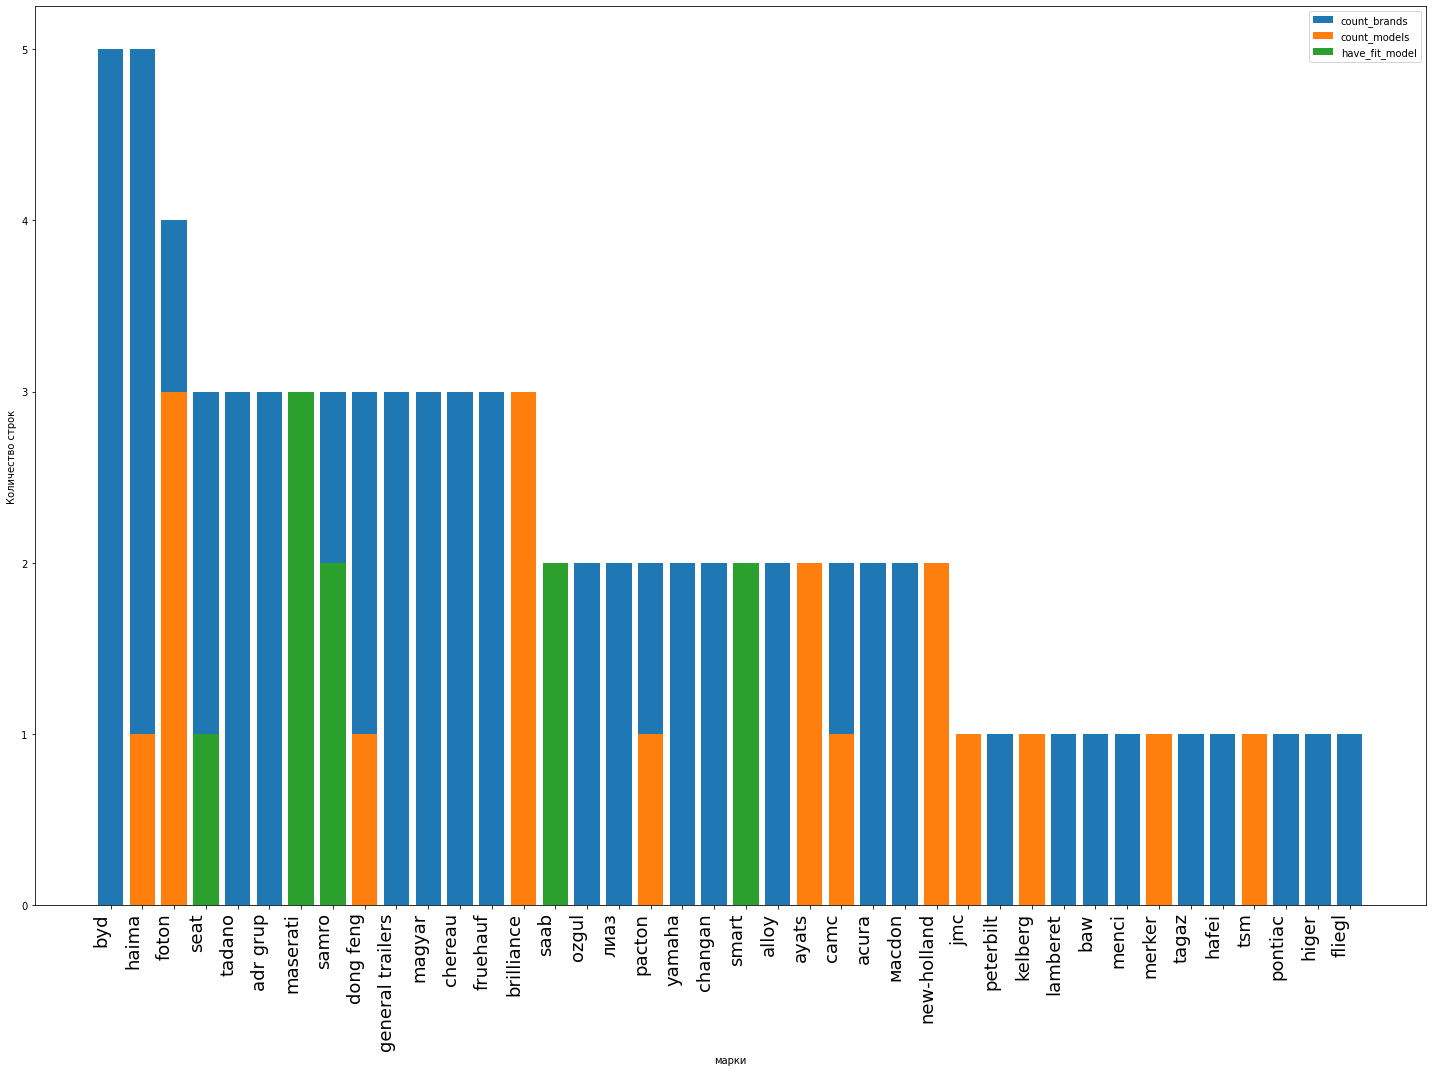

In [15]:
show_bar_model(data, 80, 120)

In [16]:
finaly_df = show_table(data=data, brand = 'scania', start=0, end=400)
finaly_df.style

Count rows  58


,HTML,brands,models,have_fit_model,count_brands,count_models
id,,,,,,
48,SCANIA BRAND R124CB6X6HZ3602003 Г.В.ПТС: 77 ТM 063767 от 15/10/2003 г. Цвет белый.,scania,,False,1,0
202,ГРУЗОВОЙ ТЯГАЧ СЕДЕЛЬНЫЙ SCANIA BRAND P 400 CA6X4HSZ 2013 года выпуска,scania,,False,1,0
252,SCANIA BRAND G 400 MODEL LA4X2HNA грузовой тягач седельный2012 года выпуска,scania,mercedes-benz_g-class,False,1,1
303,ИПВ 6730T4 Грузовой самосвал SCANIA BRAND P380 2011 г.в.,scania,,False,1,0
304,ИПВ 6730Т4 (Грузовой самосвал SCANIA BRAND P380) 2011 г.в.,scania,,False,1,0
313,Грузовой тягач седельный SCANIA BRAND R400LA4X2HLA,scania,,False,1,0
314,Грузовой тягач седельный SCANIA BRAND R400LA4X2HLA,scania,,False,1,0
315,Грузовой тягач седельный SCANIA BRAND R400LA4X2HLA,scania,,False,1,0
316,Грузовой тягач седельный SCANIA BRAND R400LA4X2HLA,scania,,False,1,0


In [20]:
finaly_df = show_empty_brand(data=data, start=0, end=400)
finaly_df.style

Count rows  1719


,HTML,brands,models,have_fit_model,count_brands,count_models
id,,,,,,
0,Автомобиль,,,False,0,0
8,Автомобиль,,,False,0,0
9,bvv,,,False,0,0
65,Марка-Экскаватор Одноковшовый ЭО-2202 Год выпуска 2010 Заводской № машины (рамы) 00229/808102344 Номер двигателя 511316 Коробка передач № 323993 Основной ведущий мост (мосты) № 622219/0710302-04 Цвет сине-желтый Вид движения колесный Регистрационный знак 22 МС 8730 паспорт самоходной машины ВЕ 416060,,,False,0,0
86,Грузовой-тягач специальный2012 г.в.гос.номер Х692РН69марка 470104 на шасси МЕRCEDES-BENZмодель № двиг. ОМ501LА54197600499190шасси WDB9340321L192438 цвет белыймощность двиг. 320 л.с.раб. V MODEL двиг. 11946 куб.см.разрешенная макс. масса 18000 кг.масса без нагрузки 7000 кг.страна Россия,,mercedes-benz_v-class,False,0,1
95,Полуприцеп-топливнозаправщик ППЦТ-176; 2012 года выпускацвет: белыйПТС №31 НМ 669567 выдан 20.07.2012 адрес местонахождения: г.Владимирмкр.Юрьевецул.Ноябрьскаяд.138.,,,False,0,0
96,Полуприцеп-топливнозаправщик ППЦТ-27; 2012 года выпускацвет: белыйПТС №31 НМ 669568 выдан 20.07.2012 адрес местонахождения: г.Владимирмкр.Юрьевецул.Ноябрьскаяд.138.,,,False,0,0
97,Автопогрузчик HELI CPQD15 (FG15) ; 2012 года выпускацвет: оранжевыйТС №233057 выдан 09.12.2012 адрес местонахождения: г.Владимирмкр.Юрьевецул.Ноябрьскаяд.138.,,,False,0,0
108,АВТОМОБИЛЬ-ФУРГОН23210ВБ 207 гшода выпускацвет - белый,,,False,0,0
